In [1]:

import matplotlib.pyplot as plt

plt.style.use('classic')

from skyfield.api import load

import pygame
import time
import numpy as np

pygame 2.1.2 (SDL 2.0.18, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Calculations

In [2]:
ts = load.timescale()

time_range = ts.utc(1970,7 , range(1,10000))
planets = load('de421.bsp')
sun = planets['sun']


In [3]:
RADIUS=40
SUN = 400 # screen pos. in pixels
WHITE = (255, 255, 255)
YELLOW = (255, 255, 0)
BLUE = (100, 149, 237)
RED = (188, 39, 50)
DARK_GREY = (80, 78, 81)
GREEN = (0,100,0)
ORANGE = (255,140,0)
DARK_ORANGE = (196, 123, 27)

SCALE = 300 / 1.524


In [4]:
class Planet():
    def __init__(self,object,name,radius=None,color=None,year_l=None,pic=None):
        planet = planets[object]
        
        self.at_tr = planet.at(time_range)
        self.pos = (planet.at(time_range) - sun.at(time_range)).position.au
        self.radius = RADIUS * radius
        self.x = SUN + self.pos[0][:] * SCALE  #positions on the screen
        self.y = SUN + self.pos[1][:] * SCALE
        self.name = name
        self.color = color
        self.year = year_l   #earth days per planet year
        self.pic_name = pic
        self.avg_to_earth = []
        
        
        if name !='Earth': #distance to earth is calculated for all planets except Earth
            self.to_earth_distance = (self.at_tr - Earth.at_tr).distance().au
        
    

Earth = Planet('earth','Earth',1,GREEN,365,'/earth.png')

Mercury = Planet(1, 'Mercury', 1, DARK_GREY,88,'/mercury.png')
Venus = Planet('venus', 'Venus', 1, ORANGE,225,'/venus.png')
Mars = Planet(4, 'Mars', 1, RED,687,'/mars.png')
Jupyter = Planet(5, 'Jupyter', 2.5, DARK_ORANGE,4329,'/jupyter.png')





Planets = [Earth, Mercury, Venus, Mars,Jupyter]
Other_Planets = [Mercury, Venus, Mars,Jupyter]



In [5]:
#CORDS FOR 1 CIRCLE OF ORBIT
for planet in Planets:
    planet.orbit_cords = [(planet.x[i],planet.y[i]) for i in range(planet.year)]

In [6]:
#GET LIST OF CLOSEST PLANETS FOR EVERY DAY
closest_planets = [] 
for z in zip(Mercury.to_earth_distance,Venus.to_earth_distance,Mars.to_earth_distance,Jupyter.to_earth_distance):
    closest_planets.append(Other_Planets[z.index(min(z))])


In [7]:
#history of percentages being closest to earth
for planet in Other_Planets:
    planet.days_closest = 0
    planet.perc = [0]
for days_elapsed, i in enumerate(time_range):
    cl_planet = closest_planets[days_elapsed]
    cl_planet.days_closest +=1
    
    for planet in Other_Planets:
        
        planet.perc.append(round(100*planet.days_closest / (days_elapsed+1),2) )

# for planet in Other_Planets:
#     planet.perc = closest_planets.count(planet)*100/len(time_range)
#     print(f'{planet.name} is closest to Earth {planet.perc}% of time')

In [8]:
#GET LIST OF AVERAGE DISTANCE TO EARTH FROM DAY 0 TO CURRENT DAY
for i in range(len(time_range)):
    for planet in Other_Planets:
        planet.avg_to_earth.append(round(np.mean(planet.to_earth_distance[:i+1]),4))
        
#GET AVERAGE DISTANCE FOR THE WHOLE PERIOD
# for planet in Other_Planets:
#     planet.avg_to_earth = round(np.mean(planet.to_earth_distance),4)
#     print(f'avg distance from {planet.name} to Earth is {planet.avg_to_earth}')


In [9]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# Animations

In [10]:
class Button():
    def __init__(self,x,y,image,scale):
        width,height = image.get_width(),image.get_height()
        self.image = pygame.transform.scale(image,((int(width*scale)),int(height*scale)))
        self.rect = self.image.get_rect()
        self.rect.topleft = (x,y)
        self.clicked = False
        
    def draw_pause_play(self,win):
        pos = pygame.mouse.get_pos()
        self.clicked = False
        if self.rect.collidepoint(pos):
            if pygame.mouse.get_pressed()[0]:
                self.clicked = True
                time.sleep(0.2)
        win.blit(self.image,(self.rect.x,self.rect.y))
        return self.clicked
    def draw_arrow(self,win,s):
        win.blit(self.image,(self.rect.x,self.rect.y))
        pos = pygame.mouse.get_pos()
        if self.rect.collidepoint(pos) and pygame.mouse.get_pressed()[0]:
            
            time.sleep(0.2)
            
            global FPS 
            FPS = FPS + 30*s
            
        

In [11]:
pygame.init()
global FPS 
FPS = 120
a = 120
WIDTH, HEIGHT = 1400, 750
WIN = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("PLanet Animation")

FONT = pygame.font.SysFont("comicsans", 24)
smaller_FONT = pygame.font.SysFont("comicsans", 16)

#loading images (not planets)
bg_pic = pygame.image.load('./pictures/space.jpg').convert_alpha()
bg_pic = pygame.transform.scale(bg_pic, (WIDTH, HEIGHT))
pause_image = pygame.image.load('./pictures/pause.png').convert_alpha()
play_image = pygame.image.load('./pictures/play.png').convert_alpha()
arrowForward_image = pygame.image.load('./pictures/button_fast_forward.png').convert_alpha()
arrowBack_image = pygame.transform.flip(arrowForward_image,1,0)

#creating button objects
pause_button = Button(500, 20, pause_image, 0.7)
play_button = Button(500, 20, play_image, 0.7)
fastF_button = Button(700,20,arrowForward_image,0.7)
fastB_button = Button(600,20,arrowBack_image,0.7)


def draw(win, i):
    update_images(i)

    #draw every planet and orbit
    for planet in Planets:
        pygame.draw.lines(win, planet.color, True, planet.orbit_cords)
        win.blit(planet.pic, planet.rect)

    #draw sun
    win.blit(sun_pic, sun_rect)
    
    #draw line connecting closest planet and earth at the moment
    pygame.draw.line(win, WHITE, (Earth.x[i], Earth.y[i]),
                     (closest_planets[i].x[i], closest_planets[i].y[i]))

    #show current date
    date_text = FONT.render(time_range[i].utc_strftime(), 1, WHITE)
    win.blit(date_text, (20, 20))

    #SHOW TABLE
    win.blit(smaller_FONT.render(f'% of time being|                   |', 1, WHITE),
                 (835, 100))
    win.blit(smaller_FONT.render(f'closest to Earth|                   |', 1, WHITE),
                 (830, 120))
    win.blit(smaller_FONT.render(f'avg distance', 1, WHITE),
                 (960, 110))
    win.blit(smaller_FONT.render(f'current distance', 1, WHITE),
                 (1060, 110))


    for planet, height in zip(Other_Planets, [145, 170, 195, 220]):
        win.blit(FONT.render(f'{planet.name}:', 1, WHITE),
                 (750, height))
        win.blit(FONT.render(f'{planet.perc[i]} %', 1, WHITE),
                 (860, height))
                 
        win.blit(FONT.render(f'|{planet.avg_to_earth[i]}', 1, WHITE),
                 (950, height))

        win.blit(FONT.render(f'|{round(planet.to_earth_distance[i],4)}', 1, WHITE),
                 (1050, height))
        

    #draw FPS counter
    win.blit(FONT.render(f'{FPS}дней/сек', 1, WHITE), (350, 20))

#planets and sun images initialization 
def load_images():
    for planet in Planets:
        pic = pygame.image.load(f'./pictures{planet.pic_name}')
        planet.pic = pygame.transform.scale(pic,(planet.radius,planet.radius))

    global sun_pic,sun_rect
    sun_pic = pygame.transform.scale(pygame.image.load('./pictures/sun.png'),(RADIUS,RADIUS))
    sun_rect = sun_pic.get_rect()
    sun_rect.center = SUN,SUN

#correcting rectangle center with each step
def update_images(i):
    for planet in Planets:
        planet.rect = planet.pic.get_rect()
        planet.rect.center = planet.x[i], planet.y[i]
    

def main():
    run = True
    paused = True
    clock = pygame.time.Clock()
    load_images()
    i = 0

    while run:
        try:

            clock.tick(FPS)
            WIN.blit(bg_pic, (0, 0))

            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    run = False

            draw(WIN, i)

            #FPS CHANGE
            fastF_button.draw_arrow(WIN,1)
            fastB_button.draw_arrow(WIN,-1)
            #FPS CHANGE

            #PAUSE
            if not paused:
                i += 1
                if pause_button.draw_pause_play(WIN):
                    paused = not paused
            else:
                if play_button.draw_pause_play(WIN):
                    paused = not paused
            #PAUSE

            pygame.display.update()

        except:
            pygame.quit()
            raise StopExecution
    pygame.quit()


main()


# Result

ValueError: x must be 1D

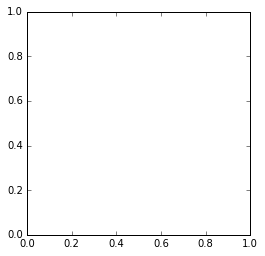

In [13]:
fig, ax = plt.subplots()
info = [planet.perc for planet in Other_Planets[:-1]]
labels = 'Меркурий','Венера','Марс'
p,t,autotexts = ax.pie(info, colors=['tab:gray','tab:orange','tab:red'], autopct='%1.2f%%', labels = labels,
       wedgeprops={"linewidth": 1, "edgecolor": "white"},
       textprops={'fontsize': 16,'color' : 'black'},
       frame=True,startangle=90)
plt.setp(autotexts, size=20, weight="bold")
# plt.title("Процент времени, который планета является ближайшей к Земле",fontsize =15)

plt.axis('off')
# plt.savefig('sample.png',bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots()
info = [planet.avg_to_earth for planet in Other_Planets[:-1]]
bar = plt.bar((1,8,15),info,4, color=['tab:gray','tab:orange','tab:red'])
ax.set_xticks((1,8,15), labels=['Меркурий','Венера','Марс'],size = 15)
ax.bar_label(bar,size = 20)
plt.title("Среднее расстояние до Земли",fontsize =15)
plt.ylabel('а.е.',fontsize = 15)
pass
# plt.savefig('averages.png',bbox_inches='tight')

# Fake result


In [ ]:
fig, ax = plt.subplots()
info = [46.93,36.78,16.29]
labels = 'Меркурий','Венера','Марс'
p,t,autotexts = ax.pie(info, colors=['tab:gray','tab:orange','tab:red'], autopct='%1.2f%%', labels = labels,
       wedgeprops={"linewidth": 1, "edgecolor": "white"},
       textprops={'fontsize': 16,'color' : 'black'},
       frame=True,startangle=90)
plt.setp(autotexts, size=19, weight="bold")
plt.title("Процент времени, который планета является ближайшей к Земле",fontsize =15)

plt.axis('off')
# plt.savefig('sample.png',bbox_inches='tight')

plt.show()

In [ ]:
fig, ax = plt.subplots()
info = [1.0392,1.1341,1.702]
bar = plt.bar((1,8,15),info,4, color=['tab:gray','tab:orange','tab:red'])
ax.set_xticks((1,8,15), labels=['Меркурий','Венера','Марс'],size = 15)
ax.bar_label(bar,size = 20)
plt.title("Среднее расстояние до Земли (5млн дней)",fontsize =15)
plt.ylabel('а.е.',fontsize = 15)